# Random Forest Fraud Detection

Random Forest classifier using scikit-learn for online payment fraud detection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report, roc_curve)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('default')
sns.set_palette('husl')
print('Libraries imported successfully')

Libraries imported successfully


## Data Loading

In [2]:
df = pd.read_csv('../onlinefraud.csv')

print(f'Dataset shape: {df.shape}')
print(f'\nDataset Info:')
df.info()

print(f'\nFirst 5 rows:')
df.head()

Dataset shape: (6362620, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Exploratory Data Analysis

In [3]:
print('Target variable distribution:')
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)
print(f'\nFraud percentage: {fraud_counts[1] / len(df) * 100:.4f}%')

print(f'\nMissing values:')
print(df.isnull().sum())

Target variable distribution:
0    6354407
1       8213
Name: isFraud, dtype: int64

Fraud percentage: 0.1291%

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Data Preprocessing

In [4]:
data = df.copy()

# Drop identifiers and flagged fraud (contains leakage)
data = data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# One-hot encode type
data = pd.get_dummies(data, columns=['type'], prefix='type')

# NO engineered features - they cause data leakage
print(f'Total features: {data.shape[1]}')


Total features: 12


In [5]:
X = data.drop(['isFraud'], axis=1)
y = data['isFraud'].values

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

# Sample 1M for better statistics
sample_size = 1000000
X_sample, _, y_sample, _ = train_test_split(
    X, y, test_size=1 - sample_size/len(X), stratify=y, random_state=42
)
print(f'\nSampled: {X_sample.shape[0]} rows')
print(f'Fraud ratio: {y_sample.sum() / len(y_sample) * 100:.4f}%')


Features shape: (6362620, 11)
Target shape: (6362620,)

Sampled: 1000000 rows
Fraud ratio: 0.1291%


In [6]:
# Train/Val/Test split: 60/20/20
# First split: 60% train+val, 40% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)
# Second split: 75% train, 25% val (of the 80%, this gives us 60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train.shape[0]} samples')
print(f'Val: {X_val.shape[0]} samples')
print(f'Test: {X_test.shape[0]} samples')
print(f'Train fraud ratio: {y_train.sum() / len(y_train) * 100:.4f}%')
print(f'Val fraud ratio: {y_val.sum() / len(y_val) * 100:.4f}%')
print(f'Test fraud ratio: {y_test.sum() / len(y_test) * 100:.4f}%')


Train: 600000 samples
Val: 200000 samples
Test: 200000 samples
Train fraud ratio: 0.1292%
Val fraud ratio: 0.1290%
Test fraud ratio: 0.1290%


## Model Training

In [7]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print('Training Random Forest...')
rf.fit(X_train_scaled, y_train)

print(f'\nModel trained with {rf.n_estimators} trees')


Training Random Forest...

Model trained with 50 trees


## Model Evaluation

In [8]:
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print('PERFORMANCE METRICS')
print('=' * 50)
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC-AUC:   {roc_auc:.4f}')
print('=' * 50)

PERFORMANCE METRICS
Accuracy:  0.9883
Precision: 0.0941
Recall:    0.9341
F1-Score:  0.1710
ROC-AUC:   0.9968


In [9]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

Confusion Matrix:
[[197423   2319]
 [    17    241]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.99      0.99    199742
       Fraud       0.09      0.93      0.17       258

    accuracy                           0.99    200000
   macro avg       0.55      0.96      0.58    200000
weighted avg       1.00      0.99      0.99    200000



In [10]:
from sklearn.metrics import precision_recall_curve

# Tune threshold on VALIDATION set (NOT test set!)
y_val_proba = rf.predict_proba(X_val_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal threshold (from VALIDATION): {optimal_threshold:.4f}')

# Evaluate on TEST set with tuned threshold
y_test_proba = rf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_test_proba >= optimal_threshold).astype(int)

# Calculate final metrics on TEST set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f'\nFINAL TEST SET METRICS (with tuned threshold):')
print('=' * 50)
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC-AUC:   {roc_auc:.4f}')
print('=' * 50)


Optimal threshold (from VALIDATION): 0.8965

FINAL TEST SET METRICS (with tuned threshold):
Accuracy:  0.9996
Precision: 0.9615
Recall:    0.6783
F1-Score:  0.7955
ROC-AUC:   0.9968


## Visualizations

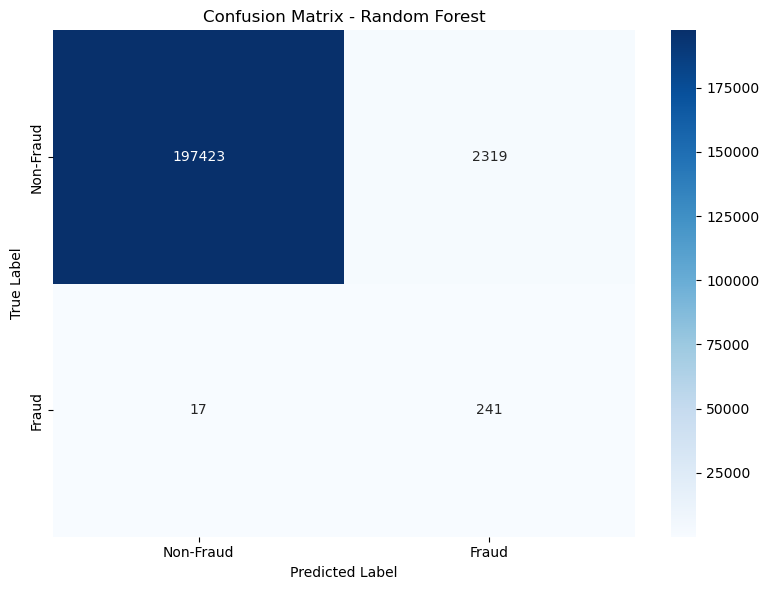

In [11]:
import os
os.makedirs('images', exist_ok=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

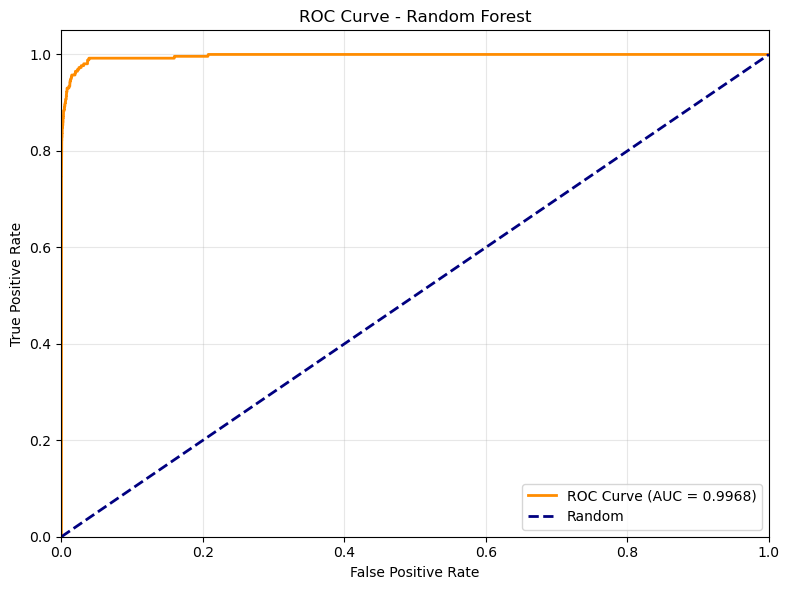

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

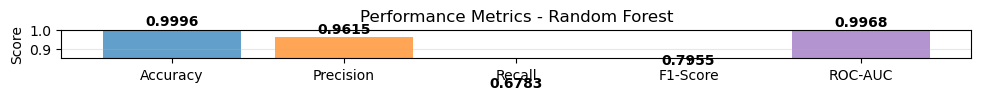

In [13]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.7)
plt.ylim([0.85, 1.0])
plt.ylabel('Score')
plt.title('Performance Metrics - Random Forest')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

In [14]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 Most Important Features:')
print(importance_df.head(15))

Top 15 Most Important Features:
           feature  importance
2    oldbalanceOrg    0.310721
3   newbalanceOrig    0.158997
1           amount    0.130299
10   type_TRANSFER    0.087380
9     type_PAYMENT    0.063581
0             step    0.058193
5   newbalanceDest    0.049608
6     type_CASH_IN    0.048856
7    type_CASH_OUT    0.047190
4   oldbalanceDest    0.045014
8       type_DEBIT    0.000160


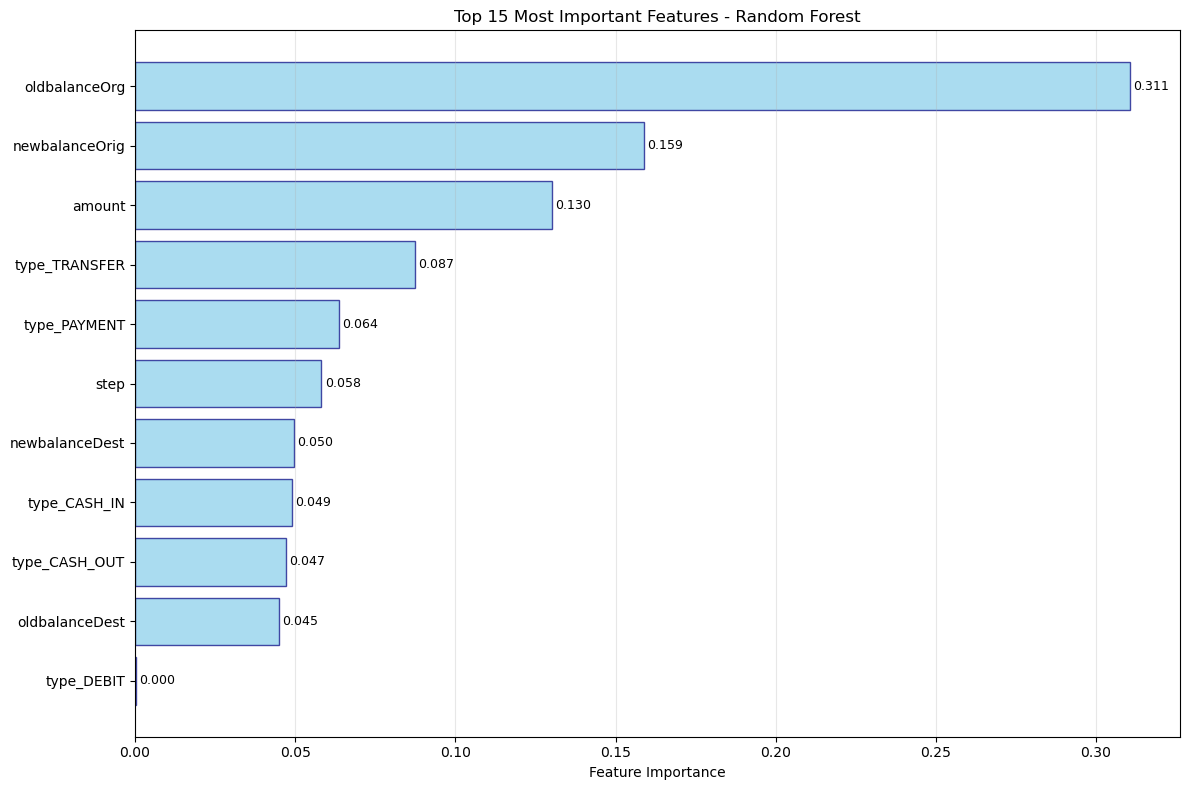

In [15]:
top_features = importance_df.head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_features['importance'], 
                color='skyblue', edgecolor='navy', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()

for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(importance + 0.001, i, f'{importance:.3f}', 
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

In [16]:
print('RANDOM FOREST FRAUD DETECTION - SUMMARY')
print('=' * 60)
print(f'\nModel Performance:')
print(f'  Accuracy: {accuracy:.4f}')
print(f'  Precision: {precision:.4f}')
print(f'  Recall: {recall:.4f}')
print(f'  F1-Score: {f1:.4f}')
print(f'  ROC-AUC: {roc_auc:.4f}')
print(f'\nKey Insights:')
print(f'  - Top features: {importance_df.head(3)["feature"].tolist()}')
print(f'  - Model trained on {len(X_train)} samples')
print(f'  - Test set: {len(X_test)} samples with {y_test.sum()} fraud cases')
print(f'  - Using class_weight=\'balanced\' to handle imbalance')
print('=' * 60)

RANDOM FOREST FRAUD DETECTION - SUMMARY

Model Performance:
  Accuracy: 0.9996
  Precision: 0.9615
  Recall: 0.6783
  F1-Score: 0.7955
  ROC-AUC: 0.9968

Key Insights:
  - Top features: ['oldbalanceOrg', 'newbalanceOrig', 'amount']
  - Model trained on 600000 samples
  - Test set: 200000 samples with 258 fraud cases
  - Using class_weight='balanced' to handle imbalance
